In [1]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras
"""

# generic imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import time
import geemap
import geojson
import ee
import pandas as pd
ee.Initialize()

# specific imports
from typing import Any, Dict, List, Optional
from geojson import Polygon, Feature, FeatureCollection, dump
from shapely.geometry import Polygon
from dateutil.relativedelta import *
from google.cloud import storage
from logging import Logger, getLogger
from googleapiclient.discovery import build
from re import sub
from ctypes import ArgumentError
from functools import partial
from dateutil.parser import parse

# custom functionality import without requirement to pip install package
local_path = r"C:\Users\kras\Documents\GitHub\ee-packages-py"  # path to local GitHub clone
sys.path.append(local_path)
from eepackages.applications.bathymetry import Bathymetry
from eepackages import tiler

logger: Logger = getLogger(__name__)

C:\Users\kras\AppData\Local\Temp\ipykernel_16700\776027900.py:11: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# Note, for generic to do's see word document on description
#TODO: implement migration to NETCDF4 with WGS84 non projected lon lat relative to MSL
#TODO: look into in-situ gauge data to be loaded (uploaded in GEE) based on input Martin (search notes)
#TODO: validate the output on in-situ data

# Project specific toggles

In [59]:
# see scheme at https://github.com/openearth/eo-bathymetry/blob/master/notebooks/rws-bathymetry/acces_api.pdf for a workflow visualization 

# project toggles
main_fol = r"p:\11209821-cmems-global-sdb" # name of the main local folder 
bucket = "cmems-sdb" # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r"p:\11209821-cmems-global-sdb\00_miscellaneous\KEYS\bathymetry-543b622ddce7.json" # Cloud Storage credential key
output_fol = "Proxy" # name of the overall project
project_name = "AOI_GER_WaddenSea_adjusted" # name of the project AoI
draw_AoI = 0 # toggle 1 to draw AoI, 0 to load

# composite image toggles, decrease the composite interval (preferred) or AoI size if running into GEE memory issues
mode = "intertidal_improved_100m" # specify mode, either "intertidal" or "subtidal"
start_date = "2021-01-01" # start date of the composites
stop_date = "2021-02-01" # end date of the composites "2022-02-01"
compo_int = 1 # composite interval [months]
compo_len = 1 # composite length [months]
scale = 100  # output resolution of the image [m]
crs = "EPSG:4326" # output projection of the image

# tiling options
zoomed_list = [9, 10, 11] # list with zoom levels to be inspected #12, 13
sel_tile = 0 # idx of chosen tile level in zoomed_list (inspect the map to chose it accordingly), z9 too big for in memory computations
# note, see https://www.openearth.nl/rws-bathymetry/2019.html; Z9 is optimal size..

# load google credentials, if specified
if not credential_file == "":  
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(credential_file)

# load GTSM & gebco data
gtsm_col = ee.FeatureCollection('projects/bathymetry/assets/gtsm_waterlevels')
gebco_image = ee.Image('projects/bathymetry/assets/gebco_2023_hat_lat')

# Pre-processing using the API

In [47]:
# draw or load Area of Interest (AoI)

# TODO: take center of AOI input file if present, put in random coordinate and let user find a place and draw a polygon
# TODO: fix horizontal tiling error (DOS) in API (to use multiple tiles) or move to single polygon run if AoI crosses multiple tiles
Map = geemap.Map(center=(54.2, 6.7), zoom=8) # initialize map with base in Hudayriat

if draw_AoI == 1:
    print("Please draw a polygon somewhere in a water body") # identifier
if draw_AoI == 0:
    # open AoI
    print("Loading and visualizing AoI") #identifier
    #AoIee = geemap.geojson_to_ee(os.path.join(main_fol,'AOI',project_name+'.geojson'))

    with open(os.path.join(main_fol, "00_miscellaneous\AOIs", project_name + ".geojson"), 'r') as f:
        contents = geojson.loads(f.read())
    AoIee = ee.Geometry(contents["features"][0]["geometry"])

    Map.addLayer(AoIee, {}, "AoI")

Map # show map

Loading and visualizing AoI


Map(center=[54.2, 6.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [51]:
# (re)construct the AoI

if draw_AoI == 1:
    
    print("Constructing AoI from drawn polygon") # identifier
    
    # get AoI 
    AoIee = ee.FeatureCollection(Map.draw_features) # make featurecollection
    AoI = Polygon(AoIee.getInfo()["features"][0]["geometry"]["coordinates"][0]) # create AoI shapefile

    # export AoI
    features = []
    features.append(Feature(geometry=AoI, properties={"AoI": project_name}))
    feature_collection = FeatureCollection(features)
    with open(os.path.join(main_fol,"00_miscellaneous\AOIs",project_name + ".geojson"), "w") as f: # geojson
        dump(feature_collection, f)
    gdr = gpd.GeoDataFrame({"properties":{"AoI": project_name}, "geometry": AoI}, crs="EPSG:4326") #shp
    gdr.to_file(os.path.join(main_fol,"00_miscellaneous\AOIs",project_name+".shp"))
    bounds = ee.Geometry.Polygon([[[a,b] for a, b in zip(*AoI.exterior.coords.xy)]])
    
if draw_AoI == 0:
    print("Reconstructing AoI from loaded file")
    # get AoI
    with open(os.path.join(main_fol,"00_miscellaneous\AOIs",project_name+".geojson")) as f:
        AoIjson = geojson.load(f)
    # try: # drawn polygon in this script
    #     AoI = Polygon(AoIjson["features"][0]["geometry"]["coordinates"]) 
    # except: # drawn in QGIS / ArcGIS and written to geojson there (client file)
    #     AoI = Polygon(AoIjson["features"][0]["geometry"]["coordinates"][0])
    #bounds = ee.Geometry.Polygon([[[a,b] for a, b in zip(*AoI.exterior.coords.xy)]])
    bounds = ee.Geometry.MultiPolygon(AoIjson["features"][0]["geometry"]["coordinates"])

Reconstructing AoI from loaded file


In [52]:
# tiling the AoI
def add_tile_bounds(zoom):
    tiled = tiler.get_tiles_for_geometry(bounds, zoom)
    Map.addLayer(tiled.style(width=max(1, 10 - zoom), fillColor= "00000022"), {}, "tiles " + str(zoom))

    return(tiled)

tiles = list(map(add_tile_bounds, zoomed_list)) # add tiles for different zoom levels

In [53]:
# Get the bounds of the AoI
# print('Bounds')
# bounds = ee.Geometry(AoIjson["features"][0]["geometry"])

# Get the tiles for the AoI
print('Tiles')
tiles = list(tiler.get_tiles_for_geometry(bounds, zoom) for zoom in zoomed_list)

Tiles


In [8]:
# export selected tiles (represented by zoom level) to geojsons
# note, adjust sel_tile accordingly 
# for idx, tile in enumerate(tiles[sel_tile].getInfo()["features"]):
#     tile_pol = Polygon(tile['geometry']['coordinates'][0]) # create tile polygon
#     tile_name = "z%s_x%s_y%s"%(tile["properties"]["zoom"], int(float(tile["properties"]["tx"])), int(float(tile["properties"]["ty"])))

#     features = []
#     features.append(Feature(geometry=tile_pol, properties={"name": tile_name}))
#     feature_collection = FeatureCollection(features)
#     feature_collection.crs = {"type": "name","properties": {"name": "epsg:3857"}} # default EE projection
#     with open(os.path.join(main_fol,"00_miscellaneous\AOI_polygons",tile_name + ".geojson"), "w") as f: # geojson
#         dump(feature_collection, f)

# Compute SDB using the API

In [9]:
tiled = tiles[sel_tile]
tx_in = "1065.0" #"1065.0" #"1053.0"
ty_in = "660.0" #"660.0" #"646.0"
tile = ee.Feature(tiled.filterMetadata("tx", "equals", tx_in).filterMetadata("ty", "equals", ty_in).first()) #11
# tile = ee.Feature(tiled.filterMetadata("tx", "equals", "4261.0").filterMetadata("ty", "equals", "2641.0").first()) #13
# tile

# buffered tile (for smoothing edges); 5 pixel agreed on with partners
tile = tile.buffer(5*scale/111120, proj="EPSG:4326") # quick fix for unequal buffer in EPSG3857: https://www.reddit.com/r/QGIS/comments/oo1jgh/buffer_points_on_epsg_4326_wgs_84/
Map.addLayer(tile, {}, "AoI_buffered")
tile

In [10]:
# export the buffered single tile
# tile_client = tile.getInfo()
# tile_pol = Polygon(tile_client['geometry']['coordinates'][0]) # create tile polygon
# tile_name = "z%s_x%s_y%s"%(tile_client["properties"]["zoom"], int(float(tile_client["properties"]["tx"])), int(float(tile_client["properties"]["ty"])))

# features = []
# features.append(Feature(geometry=tile_pol, properties={"name": tile_name}))
# feature_collection = FeatureCollection(features)
# feature_collection.crs = {"type": "name","properties": {"name": "epsg:4326"}} # default EE projection
# with open(os.path.join(main_fol,"00_miscellaneous\AOI_polygons",tile_name + "_buffered.geojson"), "w") as f: # geojson
#     dump(feature_collection, f)

In [11]:
# use supplied AOI as tile
# tile = ee.Feature(bounds)
# tile = tile.set(
#     "zoom", "12", 
#     "tx", "1065.0",
#     "ty", "660.0"
# ) # dummy values
# tile

In [12]:
# Get start and stop dates
start=ee.String(start_date)
stop=ee.String(stop_date)

bounds: ee.Geometry = ee.Feature(tile).geometry().bounds(1)
sdb: Bathymetry = Bathymetry()
zoom: ee.String = ee.String(tile.get("zoom"))
tx: ee.String = ee.String(tile.get("tx"))
ty: ee.String = ee.String(tile.get("ty"))
tile_name: ee.String = ee.String("z").cat(zoom).cat("_x").cat(tx).cat("_y").cat(ty).replace("\.\d+", "", "g")
img_fullname: ee.String = ee.String(tile_name).cat("_t").cat(ee.Date(start).millis().format())
    
image: ee.Image = sdb.compute_intertidal_depth(
    bounds=bounds,
    start=start,
    stop=stop,
    scale=tiler.zoom_to_scale(ee.Number.parse(tile.get("zoom"))).multiply(5), # scale to search for clean images
    # missions=['S2', 'L8'],
    # filter: ee.Filter.dayOfYear(7*30, 9*30), # summer-only
    filter_masked=False, 
    # filterMaskedFraction = 0.5,
    # skip_scene_boundary_fix=False,
    # skip_neighborhood_search=False,
    neighborhood_search_parameters={"erosion": 0, "dilation": 0, "weight": 50},
    bounds_buffer=0, #Note, buffer is made in epsg:3857 (google default) so its not equal away from the equator
    water_index_min=-0.05,
    water_index_max=0.15,
    # lowerCdfBoundary=45,
    # upperCdfBoundary=50,
    # cloud_frequency_threshold_data=0.15, 
    clip = True
)# .reproject(ee.Projection("EPSG:3857").atScale(90))

image = image.set(
    "fullname", img_fullname,
    "system:time_start", ee.Date(start).millis(),
    "system:time_stop", ee.Date(stop).millis(),
    "zoom", zoom,
    "tx", tx,
    "ty", ty
)

# TODO: understand the CDFquality score weighting 
# TODO: why does clip = True not work; because only clipped all the way at the end..


In [13]:
image.getInfo()

{'type': 'Image',
 'bands': [{'id': 'intertidal_elevationweighted',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [1, 1],
   'origin': [7, 53],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}],
 'properties': {'system:time_start': 1609459200000,
  'tide_spread': 66.18503814852279,
  'tx': '1065.0',
  'ty': '660.0',
  'system:footprint': {'geodesic': False,
   'type': 'Polygon',
   'coordinates': [[[7.202531611936627, 53.64013818634938],
     [7.387312142003161, 53.64013818634938],
     [7.387312142003161, 53.753210438448455],
     [7.202531611936627, 53.753210438448455],
     [7.202531611936627, 53.64013818634938]]]},
  'zoom': '11',
  'fullname': 'z11_x1065_y660_t1609459200000',
  'system:index': '0',
  'high_tide_offset': 13.37070447335735,
  'min_water_level': -0.8621443576392736,
  'low_tide_offset': 20.44425737811986,
  'gtsm_gebco_data_allempty': False,
  'max_water_level': 1.1212125777030801}}

In [14]:
# TODO:translate this to Python for system time end
# function setTimeEndIfNull(icol) {
#   var icolNoTimeEnd = icol.filter(ee.Filter.notNull(["system:time_end"]).not());
#   icolNoTimeEnd = icolNoTimeEnd.map(function (image) {
#       return image.set("system:time_end", image.get("system:time_start"));
#     }
#   );
#   return icol.merge(icolNoTimeEnd);
# }
# print(setTimeEndIfNull(imageCollection2.filterDate("2020-01-01", "2020-01-02")).toList(10));

In [15]:
# Calculate NDWI of the image
def NDWI(image):
	""" Calculates the NDWI of an image
	:param image: an image
	:type: image: ee.Image
	:return: An image with a single ndwi band
	:rtype: ee.Image
	"""
	ndwi = image.normalizedDifference(['green', 'nir']).rename("ndwi")

	return image.addBands(ndwi)

# Identify water in the image
def ndwiWater(image):
	""" Identifies water in an image based on the ndwi and a threshold value
	:param image: an image
	:type: image: ee.Image
	:return: An image where water is identified as 1 and non-water as 0
	:rtype: ee.Image
	"""
	# water threshold
	# TODO: replace by Otsu (see ppt on intertidal algs decision otsu from Kel Markert)
	ndwiThreshold = 0.2

	# find the water using a fixed NDWI threshold
	NDWIWater = image.select("ndwi").gt(ndwiThreshold).rename("ndwi_water")

	#TODO: check influence of this waterclean function on output
	# clean up the image 
	# look into dilation in morphology module
	connectedPixelSize = 512 #this can cause an internal error if set too high (1024 created errors for some cells)
	def waterClean(image, size):
		connectedPixels = image.int().connectedPixelCount(size)
		pixelCountWhere = image.where(connectedPixels.lt(size), 0)
		return pixelCountWhere

	#imageCleaned = NDWIWater
	imageCleaned = waterClean(NDWIWater, connectedPixelSize)
	imageCleanedWeight = imageCleaned.multiply(image.select("weight")).rename("ndwi_waterweight")

	time = image.get('system:time_start')

	imageCleaned.set('system:time_start', time)
	imageCleanedWeight.set('system:time_start', time)
	
	return image.addBands(imageCleaned).addBands(imageCleanedWeight)

# Add gtsm and gebco data to images
def add_gtsm_gebco_data_to_images(image, gtsm_col, tile=ee.Feature(None),
								  max_spatial_offset=1, max_temporal_offset=10):
	''' Add gtsm and gebco data to images.

	:param image: Image to which gtsm data is added.
	:type image: ee.Image
	:param gtsm_col: gtsm feature collection with water levels.
	:type gtsm_col: ee.FeatureCollection
	:param tile: Tile to which image belongs (default=None, tile geometry is determined based on image geometry).
	:type tile: ee.Feature
	:param max_spatial_offset: Maximum spatial offset in kilometers.
	:type max_spatial_offset: float (default=1)
	:param max_temporal_offset: Maximum temporal offset in minutes
	:type max_temporal_offset: float (default=10)
	'''
	
	# If tile geometry is not provided, set tile geometry to image geometry
	# tile = ee.Feature(ee.Algorithms.If(ee.Algorithms.IsEqual(tile.geometry(), None),
	# 								   ee.Feature(image.geometry()),
	# 								   tile)) # NOTE, commented out because we always map over a tile?

	# Get area around the tile
	tile_centroid = ee.Geometry.centroid(tile.geometry(), maxError=1)
	tile_footprint = ee.Geometry(tile.geometry())
	tile_buffer = tile_footprint.buffer(max_spatial_offset*1000)

	# Get period around image time
	image_time_start = ee.Date(image.get('system:time_start'))
	# image_time_end = ee.Date(ee.Algorithms.If(image.get('system:time_end'),
	# 										  ee.Date(image.get('system:time_end')),
	# 										  image_time_start))
	image_time_end = ee.Date(image.get('system:time_start')) # TODO: fix nicely with time_end.. 
	image_time = ee.Date(image_time_start.millis().add(image_time_end.millis()).divide(2))
	image_period = ee.DateRange(ee.Date(image_time_start.millis().subtract(max_temporal_offset*60*1000)),
								ee.Date(image_time_end.millis().add(max_temporal_offset*60*1000)))
	
	# Filter gtsm data based on image footprint and period
	gtsm_col = gtsm_col.filterBounds(tile_buffer)
	gtsm_col = gtsm_col.filterDate(image_period.start(), image_period.end())

	# Add spatial offset to features
	def add_spatial_offset_to_features(feature):
		return feature.set('spatial offset to image', feature.distance(ee.Feature(tile_centroid)))
	gtsm_col = gtsm_col.map(add_spatial_offset_to_features)

	# Get minimum spatial offset
	min_spatial_offset = gtsm_col.reduceColumns(ee.Reducer.min(), ['spatial offset to image']).get('min')
	
	# Get features for which the spatial offset is equal to the minimum spatial offset (multiple features possible)
	gtsm_col = gtsm_col.filter(ee.Filter.eq('spatial offset to image', min_spatial_offset))

	# Add temporal offset to features
	def add_temporal_offset_to_features(feature):
		return feature.set('temporal offset to image', ee.Number(feature.get('system:time_start')).subtract(image_time.millis()).abs())
	gtsm_col = gtsm_col.map(add_temporal_offset_to_features)

	# Get minimum temporal offset
	min_temporal_offset = gtsm_col.reduceColumns(ee.Reducer.min(), ['temporal offset to image']).get('min')

	# Get features for which the temporal offset is equal to the minimum temporal offset (multiple features possible)
	gtsm_col = gtsm_col.filter(ee.Filter.eq('temporal offset to image', min_temporal_offset))

	# Add GTSM feature to image
	image = image.set("gtsm_feature", gtsm_col.first())

	return image

# Set gtsm and gebco data to images
# TODO: Ruben gtsm_station_lon & lat does not work..
def set_gtsm_gebco_data_to_images(image, gebco_image, max_spatial_offset=1): 
	''' Add gtsm and gebco data to images.

	:param image: Image to which gtsm data is added.
	:type image: ee.Image
	:param gebco_image: gebco image with highest and lowest astronomical tide.
	:type gebco_image: ee.Image
	:param max_spatial_offset: Maximum spatial offset in kilometers.
	:type max_spatial_offset: float (default=1)
	'''

	# Get gtsm feature
	gtsm_feature = ee.Feature(image.get('gtsm_feature'))

	# Get station buffer
	station_buffer = ee.Geometry(gtsm_feature.geometry().buffer(max_spatial_offset*1000))
	
	# Get gebco highest and lowest astronomical tide data
	gebco_data = ee.Dictionary(gebco_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=station_buffer, scale=30))
	
	# Get gtsm tidal stage percentage: (WL - LAT) / (HAT - LAT) * 100
	def get_gtsm_tidal_stage_percentage(gtsm_feature, gebco_data):
		wl = ee.Number(gtsm_feature.get('waterlevel'))
		lat = ee.Number(gebco_data.get('b2'))
		hat = ee.Number(gebco_data.get('b1'))
		return wl.subtract(lat).divide(hat.subtract(lat)).multiply(100)
	
	gtsm_tidal_stage_percentage = ee.Number(get_gtsm_tidal_stage_percentage(gtsm_feature, gebco_data))
	
	# Set gtsm en gebco data to image
	image = image.set({'gtsm_gebco_data_isempty': False, # False
						'gtsm_station': gtsm_feature.get('station'),
						'gtsm_station_lon': gtsm_feature.get('lon'),
						'gtsm_station_lat': gtsm_feature.get('lat'),
						'gtsm_time': gtsm_feature.get('times'),
						'gtsm_waterlevel': gtsm_feature.get('waterlevel'),
						'gebco_hat': gebco_data.get('b1'),
						'gebco_lat': gebco_data.get('b2'),
						'gtsm_tidal_stage_percentage': gtsm_tidal_stage_percentage})
	
	# Return image
	return image

# Get the depth proxy of the image collection 
def depth_proxy(image_col):

	# filter out images without GTSM data coupled to it & sort by water level
	Collection_fil = image_col
	# GTSMCollection_fil = GTSMCollection.filter(ee.Filter.eq('gtsm_gebco_data_isempty', False))
	Collection_filsort = Collection_fil.sort("gtsm_waterlevel") # default is ascending, if applicable

	# map NDWI over entire imagecollection, either the non-filtered one (if no GTSM data was found) or the filtered one (if GTSM data was found)
	#NDWICollectionGTSM = ee.ImageCollection(GTSMCollection_filsort.map(NDWI))
	NDWICollection = ee.ImageCollection(Collection_filsort.map(NDWI))
	#NDWICollection = ee.ImageCollection(ee.Algorithms.If(empty, GTSMCollection.map(NDWI), GTSMCollection_filsort.map(NDWI)))
	#NDWICollection = sdb._refined_images.map(NDWI)

	# map to absolute pixel values (1 for water) and (0 for non-water) in NDWI images
	#NDWICollectionGTSMMapped = NDWICollectionGTSM.map(ndwiWater)
	NDWICollectionMapped = ee.ImageCollection(NDWICollection.map(ndwiWater))

	# calculate water occurrence of the collection
	waterReduceSum = NDWICollectionMapped.select("ndwi_water").reduce(ee.Reducer.sum()).int16().rename('waterOccurrenceCount') # count number of water occurrences at each pixel
	#waterReduceSum = waterReduceSum.where(waterReduceSum.eq(1), 0) #remove pixels that only have 1 for water occurence, TODO: QA check - review this
	waterPercentage = waterReduceSum.divide(NDWICollectionMapped.size()).multiply(100).rename('waterOccurrencePercentage').addBands(waterReduceSum) #calculates the water occurence % (mean*100)
	mask = waterPercentage.select('waterOccurrenceCount').mask() #adds the image collection size as a band
	bandCollectionLength = ee.Image.constant(NDWICollectionMapped.size()).uint16().rename('numberOfImagesAnalysed').updateMask(mask)
	gridCellWaterOccurrenceOutput = waterPercentage.addBands(bandCollectionLength) #add a band within the water occurrence image that holds the number of images used to calculate the water occurrence

	# weighted average (iso mean of water occurence)
	# .map(lambda i: i.select("ndwi_water").multiply(i.select("weight")))
	# TODO: check ndwi_waterweight output vs .map lambda output
	waterReduceSumWeighted = NDWICollectionMapped.select("ndwi_waterweight").reduce(ee.Reducer.sum()).int16().rename('waterOccurrenceCountWeighted') # count number of water occurrences at each pixel
	bandCollectionLengthWeighted = NDWICollectionMapped.select("weight").reduce(ee.Reducer.sum()).int16().rename('numberOfImagesAnalysedWeighted') # count number of water occurrences at each pixel
	waterPercentageWeighted = NDWICollectionMapped.select("ndwi_waterweight")\
							.sum()\
							.divide(NDWICollectionMapped.select("weight").sum())\
							.multiply(100)\
							.rename("waterOccurrencePercentageWeighted")
	gridCellWaterOccurrenceOutput = gridCellWaterOccurrenceOutput.addBands(waterPercentageWeighted).addBands(waterReduceSumWeighted).addBands(bandCollectionLengthWeighted) #add bands to the water occurrence image

	# create median NDWI band (note, not used now)
	ndwiMedian = NDWICollectionMapped.select("ndwi").median().rename('ndwiMedian') #calculate the median NDWI
	gridCellWaterOccurrenceOutput = gridCellWaterOccurrenceOutput.addBands(ndwiMedian) #add ndwiMedian as a band to the water occurrence image

	return gridCellWaterOccurrenceOutput, NDWICollectionMapped

# Get high tide offset, low tide offset and tide spread
# got rid of all ee.Algroithms.Ifs with filters: https://gis.stackexchange.com/questions/478868/update-featurecollection-property-values-based-on-condition-without-using-ee-al 
def get_tide_offsets_and_spread(image_col):
	''' Get high tide offset, low tide offset and tide spread.

	:param image_col: Image collection with gtsm and gebco data.
	:type image_col: ee.ImageCollection
	'''

	# Filter images with gtsm and gebco data
	#image_col_ = image_col.filterMetadata('gtsm_gebco_data_isempty', 'equals', False)

	# Get high tide offset & max water level
	high_tide_offset = ee.Number(ee.Number(100).subtract(ee.Number(image_col.reduceColumns(ee.Reducer.max(), ['gtsm_tidal_stage_percentage']).get('max'))))
	max_wl = ee.Number(image_col.reduceColumns(ee.Reducer.max(), ['gtsm_waterlevel']).get('max'))

	# Get low tide offset & min water level
	low_tide_offset = ee.Number(image_col.reduceColumns(ee.Reducer.min(), ['gtsm_tidal_stage_percentage']).get('min'))
	min_wl = ee.Number(image_col.reduceColumns(ee.Reducer.min(), ['gtsm_waterlevel']).get('min'))

	# Get tide spread
	tide_spread = ee.Number(ee.Number(100).subtract(high_tide_offset).subtract(low_tide_offset))

	# Add high tide offset, low tide offset and tide spread to image collection properties
	image_col = image_col.set({'gtsm_gebco_data_allempty': False,
								'high_tide_offset': high_tide_offset,
								'low_tide_offset': low_tide_offset,
								'max_water_level': max_wl,
								'min_water_level': min_wl,
								'tide_spread': tide_spread})
		
	return image_col, high_tide_offset, low_tide_offset, max_wl, min_wl, tide_spread

# Calculate the uncalibrated bathymetry
def uncalibrated_bathy(image_col):

	gridCellWaterOccurrenceOutput = image_col

	# final output image, depends if GTSM data was found if this has depths or only proxies (the latter wont be exported later..)
	out_img = ee.Image(gridCellWaterOccurrenceOutput.set({"gtsm_gebco_data_allempty": True}))
	
	# # select image to export, either water occurrence percentage (proxy, no calibrated) or depth (calibrated)
	image_bathy = ee.Image(out_img.select("waterOccurrencePercentageWeighted"))

	return image_bathy

# Calculate the calibrated bathymetry
def calibrated_bathy(image_col, NDWI_col, HTO, LTO, MAWL, MIWL, SPR):

	gridCellWaterOccurrenceOutput = image_col
	NDWICollectionGTSMMapped = NDWI_col

	# intertidal elevation and tidal stage (couple all)
	# short-cut to produce only the linear wlmax-wlmin scaled image to get the tidally corrected output with the overal (median or) mean NWDI image (water occurrence)
	# TODO: check the effect of this compared to the tidal stage intervals output.. (non-linear)
	waterElev = gridCellWaterOccurrenceOutput.select("waterOccurrencePercentage")\
				.unitScale(0, 100)\
				.multiply(ee.Number(NDWICollectionGTSMMapped.get("min_water_level")).subtract(ee.Number(NDWICollectionGTSMMapped.get("max_water_level"))))\
				.add(ee.Number(NDWICollectionGTSMMapped.get("max_water_level")))\
				.rename("intertidal_elevation")
	gridCellWaterOccurrenceOutput = gridCellWaterOccurrenceOutput.addBands(waterElev) #add intertidal elevation as a band to the water occurrence image
	waterElevWeight = gridCellWaterOccurrenceOutput.select("waterOccurrencePercentageWeighted")\
				.unitScale(0, 100)\
				.multiply(ee.Number(NDWICollectionGTSMMapped.get("min_water_level")).subtract(ee.Number(NDWICollectionGTSMMapped.get("max_water_level"))))\
				.add(ee.Number(NDWICollectionGTSMMapped.get("max_water_level")))\
				.rename("intertidal_elevationweighted")
	gridCellWaterOccurrenceOutput = gridCellWaterOccurrenceOutput.addBands(waterElevWeight) #add weighted intertidal elevation as a band to the water occurrence image

	# Add high tide offset, low tide offset and tide spread to image collection properties
	out_img = gridCellWaterOccurrenceOutput.set({'gtsm_gebco_data_allempty': False,
																	'high_tide_offset': HTO,
																	'low_tide_offset': LTO,
																	'max_water_level': MAWL,
																	'min_water_level': MIWL,
																	'tide_spread': SPR})

	# select image to export, either water occurrence percentage (proxy, no calibrated) or depth (calibrated)
	image_bathy = ee.Image(out_img.select("intertidal_elevationweighted"))

	return image_bathy

# https://developers.google.com/earth-engine/guides/ic_mapping
# Overall function to compute bathy with GTSM data
def compute_bathy_GTSM(image_col):
    # setter
    filteredGTSM = image_col

    # get tide offsets and spread
    filteredGTSM, HTO, LTO, MAWL, MIWL, SPR = get_tide_offsets_and_spread(filteredGTSM) # gives an error for empty filteredGTSM collections... might merge into calibrated bathy

    # get depth proxy
    gridCellWaterOccurrenceOutput, NDWICollectionGTSMMapped = depth_proxy(filteredGTSM)

    # calibrate the depth proxy
    image_bathy = calibrated_bathy(gridCellWaterOccurrenceOutput, NDWICollectionGTSMMapped, HTO, LTO, MAWL, MIWL, SPR)

    return image_bathy

# Overall function to compute bathy without GTSM data
def compute_proxy_NoGTSM(image_col):
    # setter
    filteredNoGTSM = image_col

    # get tide offsets and spread 
    filteredNoGTSM = filteredNoGTSM.set({'gtsm_gebco_data_allempty': True})

    # get depth proxy
    gridCellWaterOccurrenceOutput, NDWICollectionGTSMMapped = depth_proxy(filteredNoGTSM)

    # uncalibrated bathy
    image_bathy = uncalibrated_bathy(gridCellWaterOccurrenceOutput)
    
    return image_bathy

In [16]:
# see
# https://developers.google.com/earth-engine/apidocs/ee-algorithms-if
# https://developers.google.com/earth-engine/guides/client_server
# https://developers.google.com/earth-engine/guides/ic_mapping
# https://developers.google.com/earth-engine/guides/best_practices#avoid_eealgorithmsif 

# OR:
# https://gis.stackexchange.com/questions/407961/how-to-not-do-a-reduceregion-from-empty-image-collections

# combine image collections and set all empty property (0 if not all true (1), 1 if all true)
#GTSMCollection = filteredGTSM.merge(filteredNoGTSM)
#all_empty = GTSMCollection.reduceColumns(reducer=ee.Reducer.allNonZero(), selectors=['gtsm_gebco_data_isempty'])
#GTSMCollection = GTSMCollection.set('gtsm_gebco_data_allempty', all_empty.get('all'))

In [17]:
# TODO: # implement in ee_packages_py code and check..

# compute NDWI for imagecollection
# ndwi = sdb._refined_images.first().normalizedDifference(['green', 'nir']).rename("ndwi") # trial single image
# water_index_min=-0.05
# water_index_max=0.15
# ndwi = ndwi.clamp(water_index_min, water_index_max)

# map GTSM & GEBCO on the image collection
GTSMcol = sdb._refined_images.map(lambda image: add_gtsm_gebco_data_to_images(image.clip(bounds), gtsm_col, tile)) # TODO: test.clip(bounds)

filteredGTSM = GTSMcol.filter(ee.Filter.notNull(['gtsm_feature'])) # images with matching GTSM data
filteredNoGTSM = GTSMcol.filter(ee.Filter.notNull(['gtsm_feature']).Not()) # images without matching GTSM data

# map collection to set image properties
filteredGTSM = filteredGTSM.map(lambda image: set_gtsm_gebco_data_to_images(image, gebco_image))
filteredNoGTSM = filteredNoGTSM.map(lambda image: image.set({'gtsm_gebco_data_isempty': True})) #True

# Below comes a complex situation because we want to use getInfo & ee.Algorithms.if as little as possible so we need to work with map & filters, yet, we cannot succeed to get rid of all
# the ee.Algorithms.if because we have 3 options; all data in filteredGTSM, data in both filteredGTSM & filteredNoGTSM and data in only filteredNoGTSM. In case of the former two, 
# get_tide_offsets_and_spread and calibrated_bathy get data with GTSM info coupled and everything works fine. In case of the latter, it will break without if statement because these 
# functions cannot handle zero imagecollections.. The crux is really in the get_tide_offsets_and_spread. We cannot combine the two imagecollections before because it will break on data 
# without GTSM info. We also cannot combine after because it will break on an empty filteredGTSM list (latter option). Besides, we want to keep tehm seperate to calibrate the filteredGTSM
# collection if we have it.. TODO: see if we can get rid of ee.algorithms.if after all..  
# ideas: https://gis.stackexchange.com/questions/414324/handling-null-images-using-map-function-with-google-earth-engine-python-api; refactor complete functionality by giving back
# compute_intertidal_depth after step above. Then filter out the tile already that has no GTSM coupled and then continue with the calibration of tiles with GTSM. 

# compute bool_empty ImageCollection is empty
bool_empty_filGTSM = filteredGTSM.size().eq(0)
bool_empty_filNoGTSM = filteredNoGTSM.size().eq(0)

# Use two server-side conditional statements to keep memory usage low by comparing against an empty imagecollection as both true and false conditions are calculated at once. 
# See: https://developers.google.com/earth-engine/apidocs/ee-algorithms-if
image_calib = ee.Image(ee.Algorithms.If(bool_empty_filGTSM, ee.ImageCollection([]).first(), compute_bathy_GTSM(filteredGTSM)))
image_uncalib = ee.Image(ee.Algorithms.If(bool_empty_filNoGTSM, ee.ImageCollection([]).first(), compute_proxy_NoGTSM(filteredNoGTSM)))

# merge the images
image_bp = ee.ImageCollection([image_calib, image_uncalib])
image_bathy = image_bp.first() #this select the first image; image_bathy if it exists, else image_proxy

# clipping
#image.clip(bounds)

# TODO:
# creation of median images at set bins by means of water occurrence
# identify lower value of tidal stage in each bin & the mean tidal elevation
# create intertidal elevation from all images
# create tidal stage from all images

In [18]:
# print the final collection to see if it worked
image_bathy.getInfo()

{'type': 'Image',
 'bands': [{'id': 'intertidal_elevationweighted',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}],
 'properties': {'tide_spread': 66.18503814852279,
  'system:index': '0',
  'high_tide_offset': 13.37070447335735,
  'min_water_level': -0.8621443576392736,
  'low_tide_offset': 20.44425737811986,
  'gtsm_gebco_data_allempty': False,
  'max_water_level': 1.1212125777030801}}

In [14]:
# filter GTSM WL data from the image collection
properties = ['gtsm_station', 'gtsm_time', 'gtsm_waterlevel', 'gebco_hat', 'gebco_lat', 'gtsm_tidal_stage_percentage']
GTSMdata_col = GTSMCollection_fil.map(lambda i: i.set('dict', i.toDictionary(properties)))
GTSMwls = GTSMdata_col.aggregate_array('dict').getInfo()

# filter GTSM WL data from the feature collection at the station location between start and stop date
gtsm_col_st = gtsm_col.filter(ee.Filter.eq('station', np.int(np.unique([feature['gtsm_station'] for feature in GTSMwls])[0])))
gtsm_col_sts = gtsm_col_st.filterDate(start_date, stop_date)

properties = ['waterlevel', 'times']
GTSMst = gtsm_col_sts.map(lambda i: i.set('dict', i.toDictionary(properties)))
GTSMsts = GTSMst.aggregate_array('dict').getInfo()

# convert time string to time object
time_conv_wls = [pd.to_datetime(feature['gtsm_time']) for feature in GTSMwls]
time_conv_sts = [pd.to_datetime(feature['times']) for feature in GTSMsts]

# get high tide offset, low tide offset and tide spread for the imagecollection
properties = ['high_tide_offset', 'low_tide_offset', 'max_water_level', 'min_water_level', 'tide_spread']
GTSMwlsn = GTSMCollection_fil.toDictionary(properties).getInfo()

In [15]:
# gtsm tidal stage percentage: TSP = (WL - LAT) / (HAT - LAT) * 100
HTO = GTSMwlsn['high_tide_offset']
MAWL = GTSMwlsn['max_water_level']
LTO = GTSMwlsn['low_tide_offset']
MIWL = GTSMwlsn['min_water_level']
SPR = GTSMwlsn['tide_spread']

# check when these match (see noteblock); converted: WL = (TSP/100)*(HAT-LAT) + LAT
# print(np.max([feature['gtsm_waterlevel'] for feature in GTSMwls]))
# print(((100-HTO)/100)*(np.unique([feature['gebco_hat'] for feature in GTSMwls])[0]-np.unique([feature['gebco_lat'] for feature in GTSMwls])[0])+np.unique([feature['gebco_lat'] for feature in GTSMwls])[0])

# print(np.min([feature['gtsm_waterlevel'] for feature in GTSMwls]))
# print((LTO/100)*(np.unique([feature['gebco_hat'] for feature in GTSMwls])[0]-np.unique([feature['gebco_lat'] for feature in GTSMwls])[0])+np.unique([feature['gebco_lat'] for feature in GTSMwls])[0])

In [16]:
nint = 10
tidal_stages = np.linspace(0, 100, nint+1) # interval + 1
tsp = [feature['gtsm_tidal_stage_percentage'] for feature in GTSMwls]

# create tidal stage bins
sb = [] # stage bins
for idx, i in enumerate(tidal_stages):
    sbs = []
    if idx == len(tidal_stages)-1:
        break
    for j in tsp:
        if j >= i and j < tidal_stages[idx+1]:
            sbs.append(j)
    sb.append(sbs)
    print(i, tidal_stages[idx+1], len(sbs))

# only produce if 3 images, else do not produce median
# TODO: use bin function python to do the above; https://www.geeksforgeeks.org/binning-data-in-python-with-scipy-numpy/
hist, bins = np.histogram(tsp, bins=tidal_stages)
print(hist, bins)
print(sb)

0.0 10.0 0
10.0 20.0 0
20.0 30.0 2
30.0 40.0 0
40.0 50.0 2
50.0 60.0 0
60.0 70.0 0
70.0 80.0 2
80.0 90.0 1
90.0 100.0 0
[0 0 2 0 2 0 0 2 1 0] [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[[], [], [20.44425737811986, 20.44425737811986], [], [45.42017968813879, 45.42017968813879], [], [], [78.07654604972386, 78.07654604972386], [86.62929552664265], []]


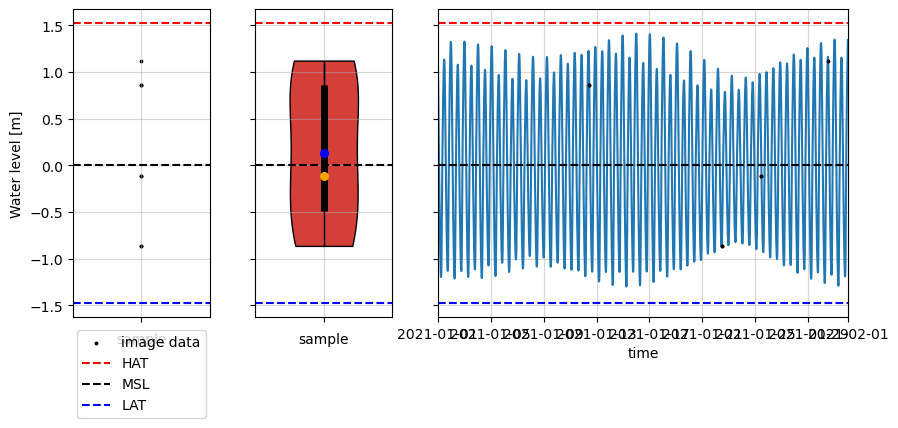

In [17]:
#%matplotlib qt
%matplotlib inline

# TODO: fix legend labels..

# plot water level distribution & characteristics of the tile
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharey=True, gridspec_kw={'width_ratios': [1, 1, 3]})

# plot 1
axs[0].scatter([1 for feature in range(len(GTSMwls))], [feature['gtsm_waterlevel'] for feature in GTSMwls], s=3, color = 'k', label="image data")
axs[0].axhline(np.unique([feature['gebco_hat'] for feature in GTSMwls])[0], color="red", linestyle="--", label="HAT")
axs[0].axhline(0, color="black", linestyle="--", label="MSL")
axs[0].axhline(np.unique([feature['gebco_lat'] for feature in GTSMwls])[0], color="blue", linestyle="--", label="LAT")
axs[0].grid(alpha=0.5)
axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35))
axs[0].set_xticks([1], labels=[''])
axs[0].set_xlabel('sample')
axs[0].set_ylabel('Water level [m]')

# plot 2
parts = axs[1].violinplot([feature['gtsm_waterlevel'] for feature in GTSMwls], showmeans=False, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile([feature['gtsm_waterlevel'] for feature in GTSMwls], [25, 50, 75])
means = np.mean([feature['gtsm_waterlevel'] for feature in GTSMwls])
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip([[feature['gtsm_waterlevel'] for feature in GTSMwls]], [quartile1], [quartile3])])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len([medians]) + 1)
axs[1].axhline(np.unique([feature['gebco_hat'] for feature in GTSMwls])[0], color="red", linestyle="--", label="HAT")
axs[1].axhline(0, color="black", linestyle="--", label="MSL")
axs[1].axhline(np.unique([feature['gebco_lat'] for feature in GTSMwls])[0], color="blue", linestyle="--", label="LAT")
axs[1].scatter(inds, medians, marker='o', color='orange', s=30, zorder=3, label="median")
axs[1].scatter(inds, means, marker='o', color='blue', s=30, zorder=3, label="mean")
axs[1].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
axs[1].vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
axs[1].boxplot([feature['gtsm_waterlevel'] for feature in GTSMwls], widths=0.1, showfliers=True, showbox=False, showcaps=False, medianprops=dict(linewidth=0)) # show flier if applicable
axs[1].grid(alpha=0.5)
axs[1].set_xticks([1], labels=[''])
axs[1].set_xlabel('sample')

axs[2].axhline(np.unique([feature['gebco_hat'] for feature in GTSMwls])[0], color="red", linestyle="--", label="HAT")
axs[2].axhline(0, color="black", linestyle="--", label="MSL", zorder=15)
axs[2].axhline(np.unique([feature['gebco_lat'] for feature in GTSMwls])[0], color="blue", linestyle="--", label="LAT")
axs[2].plot(time_conv_sts, [feature['waterlevel'] for feature in GTSMsts], label="GTSM data")
axs[2].scatter(time_conv_wls, [feature['gtsm_waterlevel'] for feature in GTSMwls], s=3, color = 'k', zorder=12, label="image data") 
axs[2].set_xlim(pd.to_datetime(start_date), pd.to_datetime(stop_date))
axs[2].grid(alpha=0.5)
axs[2].set_xlabel('time')

plt.show()

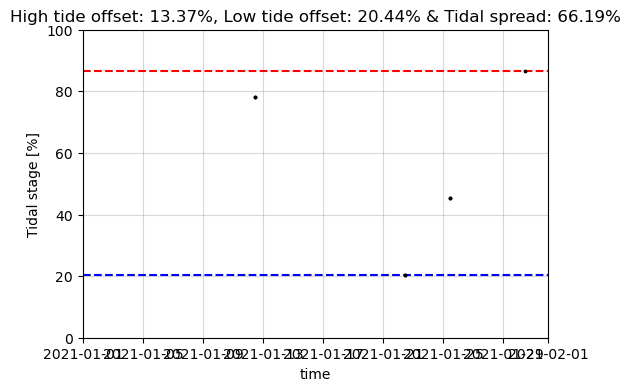

In [18]:
# plot tidal stage percentages
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

axs.scatter(time_conv_wls, [feature['gtsm_tidal_stage_percentage'] for feature in GTSMwls], s=3, color = 'k', zorder=12, label="image data") 
axs.set_xlim(pd.to_datetime(start_date), pd.to_datetime(stop_date))
axs.axhline(100-HTO, color="red", linestyle="--", label="High tide offset")
axs.axhline(LTO, color="blue", linestyle="--", label="Low tide offset")
axs.grid(alpha=0.5)
axs.set_ylim(0,100)
axs.set_xlabel('time')
axs.set_ylabel('Tidal stage [%]')
axs.set_title('High tide offset: {:.2f}%, Low tide offset: {:.2f}% & Tidal spread: {:.2f}%'.format(HTO, LTO, SPR));
#axs.legend()

In [19]:
# get array and check values
#band_arrs = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs = gridCellWaterOccurrenceOutput.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs = image.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs = waterElev.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arr = band_arrs.get('ndwi')
# band_arr = band_arrs.get('ndwi_waterweight')
#band_arr = band_arrs.get('weight')
# band_arr = band_arrs.get('waterOccurrenceCount')
#band_arr = band_arrs.get('waterOccurrencePercentage')
#band_arr = band_arrs.get('waterOccurrencePercentageWeighted')
# band_arr = band_arrs.get('ndwiMedian')
#band_arr = band_arrs.get("intertidal_elevation")
band_arr = band_arrs.get("intertidal_elevationweighted")
np_arr = np.array(band_arr.getInfo())
print(np_arr.shape)
print(np_arr)


(127, 207)
[[-0.86214436 -0.86214436 -0.86214436 ... -0.86214436 -0.86214436
  -0.86214436]
 [-0.86214436 -0.86214436 -0.86214436 ... -0.86214436 -0.86214436
  -0.86214436]
 [-0.86214436 -0.86214436 -0.86214436 ... -0.86214436 -0.86214436
  -0.86214436]
 ...
 [ 1.12121258  1.12121258  1.12121258 ...  1.12121258  1.12121258
   1.12121258]
 [ 1.12121258  1.12121258  1.12121258 ...  1.12121258  1.12121258
   1.12121258]
 [ 1.12121258  1.12121258  1.12121258 ...  1.12121258  1.12121258
   1.12121258]]


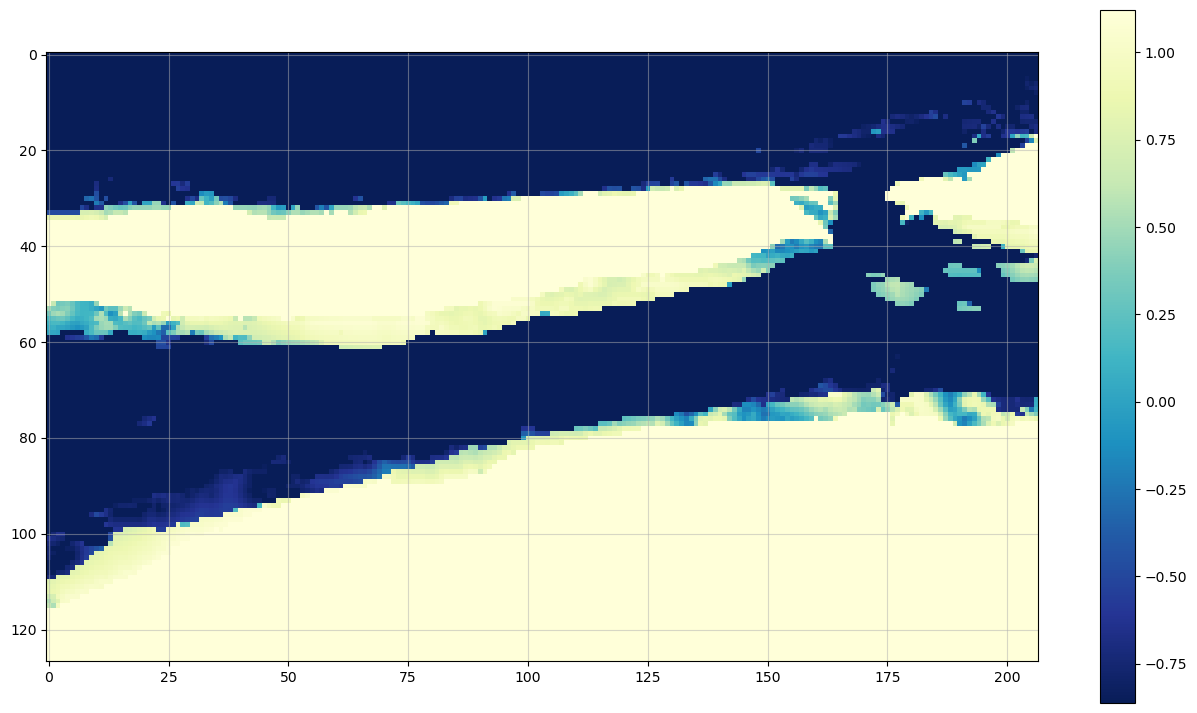

In [20]:
# plot data array
plt.figure(figsize=(16,9))
#plt.imshow(np_arr, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.imshow(np_arr, cmap="YlGnBu_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [21]:
#bathyoutput = sdb._images_calibrated
bathyoutput = image_bathy
#bathyoutput.getInfo()

# get array and check values
#band_arrs = ndwi.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
# band_arrs = NDWICollection.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs = NDWICollectionMapped.first().reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
band_arrs = bathyoutput.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arrs = waterElev.reproject(crs = ee.Projection('EPSG:4326'), scale=scale).sampleRectangle(region=bounds)
#band_arr = band_arrs.get('ndwi')
# band_arr = band_arrs.get('ndwi_waterweight')
#band_arr = band_arrs.get('weight')
# band_arr = band_arrs.get('waterOccurrenceCount')
#band_arr = band_arrs.get('waterOccurrencePercentage')
#band_arr = band_arrs.get('waterOccurrencePercentageWeighted')
# band_arr = band_arrs.get('ndwiMedian')
#band_arr = band_arrs.get("intertidal_elevation")
band_arr = band_arrs.get("intertidal_elevationweighted")
np_arr2 = np.array(band_arr.getInfo())
print(np_arr2.shape)
print(np_arr2)

(127, 207)
[[-0.86214436 -0.86214436 -0.86214436 ... -0.86214436 -0.86214436
  -0.86214436]
 [-0.86214436 -0.86214436 -0.86214436 ... -0.86214436 -0.86214436
  -0.86214436]
 [-0.86214436 -0.86214436 -0.86214436 ... -0.86214436 -0.86214436
  -0.86214436]
 ...
 [ 1.12121258  1.12121258  1.12121258 ...  1.12121258  1.12121258
   1.12121258]
 [ 1.12121258  1.12121258  1.12121258 ...  1.12121258  1.12121258
   1.12121258]
 [ 1.12121258  1.12121258  1.12121258 ...  1.12121258  1.12121258
   1.12121258]]


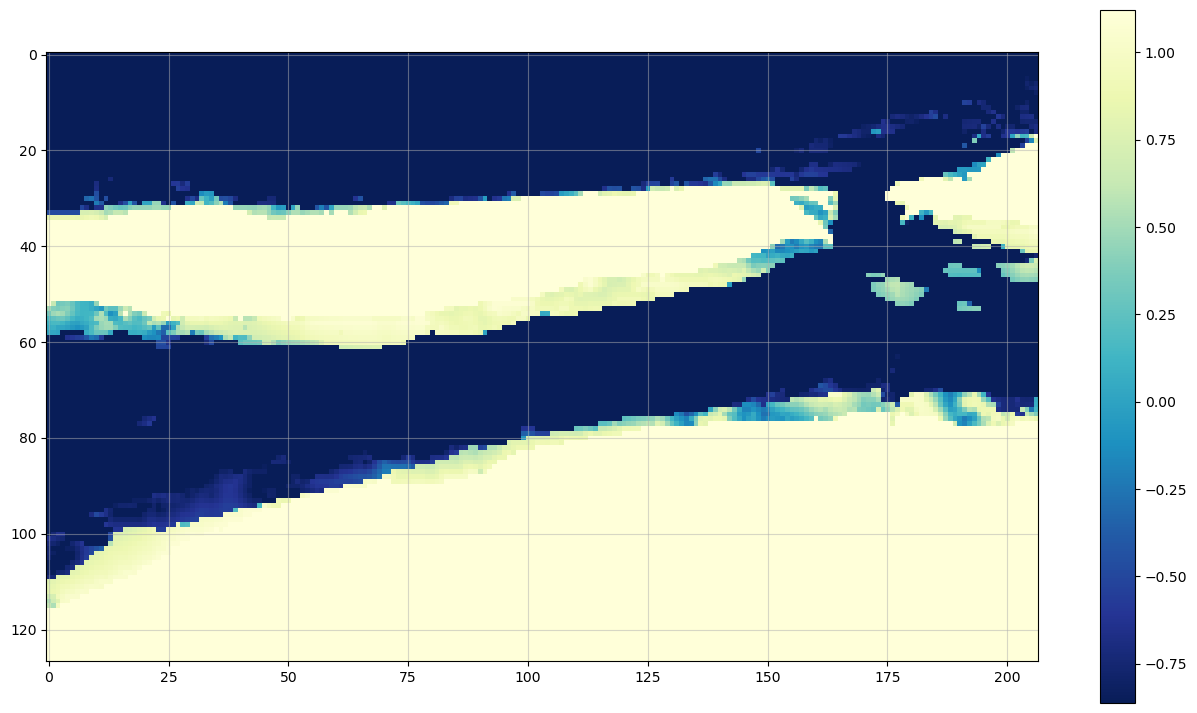

In [22]:
# plot data array
plt.figure(figsize=(16,9))
#plt.imshow(np_arr, cmap="Greys_r")#vmin=-0.05, vmax=0.15
plt.imshow(np_arr2, cmap="YlGnBu_r")#vmin=-0.05, vmax=0.15
plt.grid(alpha=0.5)
# plt.clim(0,1)
plt.colorbar()
plt.show()

In [23]:
np.all(np_arr == np_arr2)

True

In [24]:
# export the image as test (all images are exported with download_proxies.ipynb)
def tile_to_cloud_storage(
    image: ee.Image,
    tile: ee.Feature,
    scale: int,
    crs: str,
    bucket: str,
    bucket_path: str,
    overwrite: bool
) -> Optional[ee.batch.Task]:
    with build('storage', 'v1') as storage:
        res = storage.objects().list(bucket=bucket, prefix="/".join(bucket_path.split("/")[:-1])).execute()
    if not overwrite:
        try:
            object_exists = any(map(lambda item: item.get("name").startswith(bucket_path), res.get("items")))
        except AttributeError:
            object_exists = False
        if object_exists:
            logger.info(f"object {bucket_path} already exists in bucket {bucket}, skipping")
            return
        
    task: ee.batch.Task = ee.batch.Export.image.toCloudStorage(
        image,
        bucket=bucket,
        description=bucket_path.replace("/", "_"),
        fileNamePrefix=bucket_path,
        region=tile.geometry(),
        scale=scale,
        crs=crs,
        fileFormat='GeoTIFF',
        formatOptions= {'cloudOptimized': True}, # enables easy QGIS plotting
        maxPixels= 1e10
    )
    task.start()
    return task

# Only export the ones with coupled GTSM data (i.e. depth values iso proxies), cast to imagecollection to filter
sdb_tiles: ee.ImageCollection = ee.ImageCollection([image_bathy]).filter(ee.Filter.eq("gtsm_gebco_data_allempty", False))
num_tiles: int = sdb_tiles.size().getInfo()  

# Export the image to the cloud
if num_tiles == 0:
    #logger.info("No images to export")
    print("No images to export")
else: # export only calibrated images
    tile_to_cloud_storage(
        image=ee.Image(sdb_tiles.first()), # cast to image again #.select('intertidal_elevationweighted') #gridCellWaterOccurrenceOutput.
        tile=tile,
        scale=scale,
        crs=crs,
        bucket=bucket,
        bucket_path='{}/z{:0.0f}/x{:0.0f}/y{:0.0f}/t{}_{}_{}m9'.format(mode, zoomed_list[sel_tile], int(float(tx_in)), int(float(ty_in)), start_date, stop_date, scale),
        overwrite=True
    )

# NOTE: NetCDF export is not supported by Earth Engine, so we export to GeoTIFF instead (which can be converted to NetCDF using GDAL translate)

In [25]:
# check the exported tile
sdb_tiles.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'features': [{'type': 'Image',
   'bands': [{'id': 'intertidal_elevationweighted',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]}],
   'properties': {'tide_spread': 66.18503814852279,
    'system:index': '0',
    'high_tide_offset': 13.37070447335735,
    'min_water_level': -0.8621443576392736,
    'low_tide_offset': 20.44425737811986,
    'gtsm_gebco_data_allempty': False,
    'max_water_level': 1.1212125777030801}}]}

In [55]:
# functions to compute sub & intertidal bathymetry proxies based on standardized SlippyMap tiling practice
# functions taken from: https://github.com/openearth/eo-bathymetry/blob/master/notebooks/rws-bathymetry/export_bathymetry.ipynb
# resembles similar behaviour as in https://github.com/openearth/eo-bathymetry-functions but slightly adjusted for local study 

def get_tile_subtidal_bathymetry(tile: ee.Feature, start: ee.String, stop: ee.String) -> ee.Image:
    """
    Get subtidal bathymetry based on tile geometry.
    Server-side compliant for GEE.

    args:
        tile (ee.Feature): tile geometry used to obtain bathymetry.
        start (ee.String): start date in YYYY-MM-dd format.
        stop (ee.String): stop date in YYYY-MM-dd format.
    
    returns:
        ee.Image: image containing subtidal bathymetry covering tile.
    """

    bounds: ee.Geometry = ee.Feature(tile).geometry().bounds(1)
    sdb: Bathymetry = Bathymetry()
    zoom: ee.String = ee.String(tile.get("zoom"))
    tx: ee.String = ee.String(tile.get("tx"))
    ty: ee.String = ee.String(tile.get("ty"))
    tile_name: ee.String = ee.String("z").cat(zoom).cat("_x").cat(tx).cat("_y").cat(ty).replace("\.\d+", "", "g")
    img_fullname: ee.String = ee.String(tile_name).cat("_t").cat(ee.Date(start).millis().format())
        
    image: ee.Image = sdb.compute_inverse_depth(
                bounds=bounds,
                start=start,
                stop=stop,
                scale=tiler.zoom_to_scale(ee.Number.parse(tile.get("zoom"))).multiply(5), # scale to search for clean images
                missions=["S2", "L8"],
                filter_masked=True,
                skip_neighborhood_search=False
                # cloud_frequency_threshold_data=,
                # pansharpen=,
                # skip_scene_boundary_fix=,
                # bounds_buffer=
    ).clip(bounds)

    image = image.set(
        "fullname", img_fullname,
        "system:time_start", ee.Date(start).millis(),
        "system:time_stop", ee.Date(stop).millis(),
        "zoom", zoom,
        "tx", tx,
        "ty", ty
    )
    return image

def get_tile_intertidal_bathymetry(tile: ee.Feature, start: ee.String, stop: ee.String) -> ee.Image:
    """
    Get intertidal bathymetry based on tile geometry.
    Server-side compliant for GEE.

    args:
        tile (ee.Feature): tile geometry used to obtain bathymetry.
        start (ee.String): start date in YYYY-MM-dd format.
        stop (ee.String): stop date in YYYY-MM-dd format.
    
    returns:
        ee.Image: image containing intertidal bathymetry covering tile.
    """

    bounds: ee.Geometry = ee.Feature(tile).geometry().bounds(1)
    sdb: Bathymetry = Bathymetry()
    zoom: ee.String = ee.String(tile.get("zoom"))
    tx: ee.String = ee.String(tile.get("tx"))
    ty: ee.String = ee.String(tile.get("ty"))
    tile_name: ee.String = ee.String("z").cat(zoom).cat("_x").cat(tx).cat("_y").cat(ty).replace("\.\d+", "", "g")
    img_fullname: ee.String = ee.String(tile_name).cat("_t").cat(ee.Date(start).millis().format())
        
    image: ee.Image = sdb.compute_intertidal_depth(
        bounds=bounds,
        start=start,
        stop=stop,
        scale=tiler.zoom_to_scale(ee.Number.parse(tile.get("zoom"))).multiply(5), # scale to search for clean images
        # missions=['S2', 'L8'],
        # filter: ee.Filter.dayOfYear(7*30, 9*30), # summer-only
        filter_masked=False, 
        # filterMaskedFraction = 0.5,
        # skip_scene_boundary_fix=False,
        # skip_neighborhood_search=False,
        neighborhood_search_parameters={"erosion": 0, "dilation": 0, "weight": 50},
        bounds_buffer=0,
        water_index_min=-0.05,
        water_index_max=0.15,
        # lowerCdfBoundary=45,
        # upperCdfBoundary=50,
        # cloud_frequency_threshold_data=0.15, 
        clip = True
    )# .reproject(ee.Projection("EPSG:3857").atScale(90))

    image = image.set(
        "fullname", img_fullname,
        "system:time_start", ee.Date(start).millis(),
        "system:time_stop", ee.Date(stop).millis(),
        "zoom", zoom,
        "tx", tx,
        "ty", ty
    )

    return image

def tile_to_asset(
    image: ee.Image,
    tile: ee.Feature,
    export_scale: int,
    asset_path_prefix: str,
    asset_name: str,
    overwrite: bool
) -> Optional[ee.batch.Task]:
    
    asset_id: str = f"{asset_path_prefix}/{asset_name}"
    asset: Dict[str, Any] = ee.data.getInfo(asset_id)
    if overwrite and asset:
        logger.info(f"deleting asset {asset}")
        ee.data.deleteAsset(asset_id)
    elif asset:
        logger.info(f"asset {asset} already exists, skipping {asset_name}")
        return
    task: ee.batch.Task = ee.batch.Export.image.toAsset(
        image,
        assetId=asset_id,
        description=asset_name,
        region=tile.geometry(),
        scale=export_scale,
        maxPixels= 1e10
    )
    task.start()
    logger.info(f"exporting {asset_name} to {asset_id}")

def tile_to_cloud_storage(
    image: ee.Image,
    tile: ee.Feature,
    crs: str,
    export_scale: int,
    bucket: str,
    bucket_path: str,
    overwrite: bool
) -> Optional[ee.batch.Task]:
    with build('storage', 'v1') as storage:
        res = storage.objects().list(bucket=bucket, prefix="/".join(bucket_path.split("/")[:-1])).execute()
    if not overwrite:
        try:
            object_exists = any(map(lambda item: item.get("name").startswith(bucket_path), res.get("items")))
        except AttributeError:
            object_exists = False
        if object_exists:
            logger.info(f"object {bucket_path} already exists in bucket {bucket}, skipping")
            return
        
    task: ee.batch.Task = ee.batch.Export.image.toCloudStorage(
        image,
        bucket=bucket,
        description=bucket_path.replace("/", "_"),
        fileNamePrefix=bucket_path,
        region=tile.geometry(),
        scale=export_scale,
        crs=crs,
        fileFormat='GeoTIFF',
        formatOptions= {'cloudOptimized': True}, # enables easy QGIS plotting
        maxPixels= 1e10
    )
    task.start()
    return task

def export_sdb_tiles(
    sink: str,
    tile_list: ee.List,
    num_tiles: int,
    export_scale: int,
    crs: str,
    sdb_tiles: ee.ImageCollection,
    name_suffix: str,
    mode: str,
    task_list: List[ee.batch.Task],
    overwrite: bool,
    bucket: Optional[str] = None
) -> List[ee.batch.Task]:
    """
    Export list of tiled images containing sub or intertidal tidal bathymetry. Fires off the tasks and adds to the list of tasks.
    based on: https://github.com/gee-community/gee_tools/blob/master/geetools/batch/imagecollection.py#L166

    args:
        sink (str): type of data sink to export to. Viable options are: "asset" and "cloud".
        tile_list (ee.List): list of tile features.
        num_tiles (int): number of tiles in `tile_list`.
        scale (int): scale of the export product.
        sdb_tiles (ee.ImageCollection): collection of subtidal bathymetry images corresponding
            to input tiles.
        name_suffix (str): unique identifier after tile statistics.
        task_list (List[ee.batch.Task]): list of tasks, adds tasks created to this list.
        overwrite (bool): whether to overwrite the current assets under the same `asset_path`.
        bucket (str): Bucket where the data is stored. Only used when sink = "cloud"
    
    returns:
        List[ee.batch.Task]: list of started tasks

    """
    if sink == "asset":
        user_name: str = ee.data.getAssetRoots()[0]["id"].split("/")[-1]
        asset_path_prefix: str = f"users/{user_name}/eo-bathymetry"
        ee.data.create_assets(asset_ids=[asset_path_prefix], asset_type="Folder", mk_parents=True)
    
    for i in range(num_tiles):
        # get tile
        temp_tile: ee.Feature = ee.Feature(tile_list.get(i))
        tile_metadata: Dict[str, Any] = temp_tile.getInfo()["properties"]
        tx: str = tile_metadata["tx"]
        ty: str = tile_metadata["ty"]
        zoom: str = tile_metadata["zoom"]
        # filter imagecollection based on tile
        filtered_ic: ee.ImageCollection = sdb_tiles \
            .filterMetadata("tx", "equals", tx) \
            .filterMetadata("ty", "equals", ty) \
            .filterMetadata("zoom", "equals", zoom)
        # if filtered correctly, only a single image remains
        img: ee.Image = ee.Image(filtered_ic.first())  # have to cast here
        img_name: str = sub(r"\.\d+", "", f"{mode}/z{zoom}/x{tx}/y{ty}/") + name_suffix 
        print("Submitting task for tile: ", img_name)
        # Export images
        if sink == "asset":  # Replace with case / switch in python 3.10
            task: Optional[ee.batch.Task] = tile_to_asset(
                image=img,
                tile=temp_tile,
                export_scale=export_scale,
                asset_path_prefix=asset_path_prefix,
                asset_name=img_name.replace("/","_"),
                overwrite=overwrite
            )
            if task: task_list.append(task)
        elif sink == "cloud":
            if not bucket:
                raise ArgumentError("Sink option requires \"bucket\" arg.")
            task: ee.batch.Task = tile_to_cloud_storage(
                image=img,
                tile=temp_tile,
                export_scale=export_scale,
                crs=crs, 
                bucket=bucket,
                bucket_path=img_name,
                overwrite=overwrite
            )
        else:
            raise ArgumentError("unrecognized data sink: {sink}")
        task_list.append(task)
    return task_list

def export_tiles(
    sink: str,
    mode: str,
    geometry: ee.Geometry,
    zoom: int,
    start: str,
    stop: str,
    scale: Optional[float] = None,
    crs: str = "EPSG:4326",
    buf_pix: int = 0,
    step_months: int = 3,
    window_months: int = 24,
    overwrite: bool = False,
    bucket: Optional[str] = None
) -> None:
    """
    From a geometry, creates tiles of input zoom level, calculates subtidal bathymetry in those
    tiles, and exports those tiles.

    args:
        sink (str): type of data sink to export to. Viable options are: "asset" and "cloud".
        mode (str): either "subtidal" or "intertidal" for select type of bathymetry to export.
        geometry (ee.Geometry): geometry of the area of interest.
        zoom (int): zoom level of the to-be-exported tiles.
        start (ee.String): start date in YYYY-MM-dd format.
        stop (ee.String): stop date in YYYY-MM-dd format.
        scale Optional(float): scale of the product to be exported. Defaults tiler.zoom_to_scale(zoom).getInfo().
        crs (str): projection of the output image.
        buf_pix (int): buffer around the tile (in pixels).
        step_months (int): steps with which to roll the window over which the subtidal bathymetry
            is calculated.
        windows_months (int): number of months over which the bathymetry is calculated.
    """

    def create_year_window(year: ee.Number, month: ee.Number) -> ee.Dictionary:
        t: ee.Date = ee.Date.fromYMD(year, month, 1)
        d_format: str = "YYYY-MM-dd"
        return ee.Dictionary({
            "start": t.format(d_format),
            "stop": t.advance(window_months, 'month').format(d_format)
            })
    
    window_length: int = (parse(stop).year-parse(start).year)*12+(parse(stop).month-parse(start).month) # in months
    dates: ee.List = ee.List.sequence(parse(start).year, parse(stop).year-window_months/12).map(
        lambda year: ee.List.sequence(1, None, step_months, int((window_length-window_months)/step_months)+1).map(partial(create_year_window, year))
    ).flatten() # NOTE, still buggy, works for yearly composites. Not nice for end_date "2022-03-01"; error Date.fromYMD: Bad year/month/day: 2021/13/1.
    
    dates = ee.List([dates.get(0)]) #ADJUSTED TO SELECT FIRST DATE ONLY
    
    # Get tiles
    tiled: ee.FeatureCollection = tiler.get_tiles_for_geometry(geometry, ee.Number(zoom)) # ADJUSTED TO SELECT SINGLE TILE
    tiles: ee.FeatureCollection = tiled.map(lambda tile: tile.buffer(buf_pix*scale/111120, ee.ErrorMargin((buf_pix*scale*0.01)/111120, 'projected'), proj="EPSG:4326")) # fix for unequal buffer in EPSG3857: https://www.reddit.com/r/QGIS/comments/oo1jgh/buffer_points_on_epsg_4326_wgs_84/
    #tiledb: ee.FeatureCollection = tiled.map(lambda tile: tile.buffer(buf_pix*scale/111120, ee.ErrorMargin((buf_pix*scale*0.01)/111120, 'projected'), proj="EPSG:4326")) # ADJUSTED TO SELECT SINGLE TILE & fix for unequal buffer in EPSG3857: https://www.reddit.com/r/QGIS/comments/oo1jgh/buffer_points_on_epsg_4326_wgs_84/
    #tile: ee.Feature = ee.Feature(tiledb.filterMetadata("tx", "equals", tx_in).filterMetadata("ty", "equals", ty_in).first()) #11 #ADJUSTED TO SELECT SINGLE TILE
    #tiles: ee.FeatureCollection = ee.FeatureCollection(tile) #ADJUSTED TO SELECT SINGLE TILE

    if scale == None: scale: float = tiler.zoom_to_scale(zoom).getInfo() # not specified, defaults to pre-set float
    else: scale: scale # specified
    task_list: List[ee.batch.Task] = []
    #num_tiles: int = tiles.size().getInfo()
    #tile_list: ee.List = tiles.toList(num_tiles)

    for date in dates.getInfo():
        #print(date)
        if "subtidal" in mode:
            sdb_tiles: ee.ImageCollection = tiles.map(
                lambda tile: get_tile_subtidal_bathymetry(
                    tile=tile,
                    start=ee.String(date["start"]),
                    stop=ee.String(date["stop"])
                )#.clip(geometry) # clip individual tiles to match geometry of aoi
            )
        elif "intertidal" in mode:
            sdb_tiles: ee.ImageCollection = tiles.map(
                lambda tile: get_tile_intertidal_bathymetry(
                    tile=tile, 
                    start=ee.String(date["start"]),
                    stop=ee.String(date["stop"])
                )#.clip(geometry)#.select('ndwi').rename('water_score') # clip individual tiles to match geometry of aoi, select ndwi and rename
            )

        return sdb_tiles

        # only export the ones with coupled GTSM data (i.e. depth values iso proxies)
        sdb_tile_prop: ee.FeatureCollection = sdb_tiles.select("gtsm_gebco_data_allempty") # ADDED filter GTSM data availability property
        innerJoin = ee.Join.inner('primary', 'secondary') # ADDED construct join function
        joined_tiles = innerJoin.apply(tiles, sdb_tile_prop, ee.Filter.equals(leftField= "id", rightField= "id")) # ADDED join tiles & sdb_tiles on id
        joined_tiles_clean = joined_tiles.map(lambda feature: ee.Feature(feature.get('primary')).copyProperties(feature.get('secondary'))) # ADDED clean up joined tiles, keeping the tiles and only adding the selected property
        tile_list: ee.FeatureCollection  = joined_tiles_clean.filterMetadata("gtsm_gebco_data_allempty", "equals", False) #ADDED TO UPDATE EXPORT FOR ONLY CALIBRATED IMAGES
        sdb_tiles_up: ee.ImageCollection = sdb_tiles.filterMetadata("gtsm_gebco_data_allempty", "equals", False) #ADDED TO UPDATE EXPORT FOR ONLY CALIBRATED IMAGES
        num_tiles: int = sdb_tiles_up.size().getInfo()  #ADDED TO UPDATE EXPORT FOR ONLY CALIBRATED IMAGES

        if num_tiles > 0:  #ADDED TO UPDATE EXPORT FOR ONLY CALIBRATED IMAGES
            tile_list_up: ee.List = tile_list.toList(num_tiles)  #ADDED TO UPDATE EXPORT FOR ONLY CALIBRATED IMAGES

            # Now export tiles
            export_sdb_tiles(
                sink=sink,
                tile_list=tile_list_up,
                num_tiles=num_tiles,
                mode=mode,
                export_scale=scale,
                crs=crs,
                sdb_tiles=sdb_tiles_up,
                name_suffix=f"t{date['start']}_{date['stop']}_{scale}m7",
                task_list=task_list,
                overwrite=overwrite,
                bucket=bucket
            )

In [60]:
# export bathymetry based on standardized tiling practice
allfiles = os.listdir(os.path.join(main_fol, "00_miscellaneous\AOIs"))
tiled = []
for i in allfiles:
    if i.endswith("_adjusted.geojson") and not "CMEMS" in i and ("GER" in i):# or "BRA" in i or "ZAF" in i):
        print(i)
        with open(os.path.join(main_fol,"00_miscellaneous\AOIs",i)) as f:
            AoIjson = geojson.load(f)
        # try: # drawn polygon in this script
        #     AoI = Polygon(AoIjson["features"][0]["geometry"]["coordinates"]) 
        # except: # drawn in QGIS / ArcGIS and written to geojson there (client file)
        #     AoI = Polygon(AoIjson["features"][0]["geometry"]["coordinates"][0])
        # bounds = ee.Geometry.Polygon([[[a,b] for a, b in zip(*AoI.exterior.coords.xy)]])
        bounds = ee.Geometry.MultiPolygon(AoIjson["features"][0]["geometry"]["coordinates"])

        sdb_tiles = export_tiles(sink="cloud", mode=mode, geometry=bounds, zoom=zoomed_list[sel_tile], start=start_date, stop="2022-01-01", 
                     crs=crs, scale=scale, buf_pix=5, step_months=compo_int, window_months=compo_len, overwrite=True, bucket=bucket)

AOI_GER_WaddenSea_adjusted.geojson


In [62]:
sdb_tiles

In [28]:
sdb_tiles.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'features': [{'type': 'Image',
   'bands': [{'id': 'intertidal_elevationweighted',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]}],
   'properties': {'tide_spread': 66.18503814852279,
    'system:index': '0',
    'high_tide_offset': 13.37070447335735,
    'min_water_level': -0.8621443576392736,
    'low_tide_offset': 20.44425737811986,
    'gtsm_gebco_data_allempty': False,
    'max_water_level': 1.1212125777030801}}]}

In [ ]:
#continue

# move to intertidal elevation and tidal stage ... (calibration)
# scale up to all case study areas and assess the results

# think about QA params to export

# look into the boundary artefacts of the tiles (buffer them)

# use the countours to interpolate (TIN, see Bisschop-Taylor) the bathymetry
# TODO: check the duplicate times in the composite image (get rid of them)
# validation!

# import intertidal feas layer (?)
# combine work methods...

In [36]:
# Plot images (interactively)
Map = geemap.Map()
Map.centerObject(bounds, 9)
Map.addLayer(bounds, {}, "AoI")
# from tqdm import tqdm
# for idx in tqdm(range(sdb._raw_images.size().getInfo())):
#     image_ = ee.Image(sdb._raw_images.toList(sdb._raw_images.size()).get(idx))
#     Map.addLayer(image_, {"bands": ["red", "green", "blue"], "min": 0, "max": 0.3}, f"image_{idx} (date: {dates[idx]})")
#     if idx > 1:
#         break
Map

Map(center=[53.696663843187544, 7.294921876971232], controls=(WidgetControl(options=['position', 'transparent_…

In [38]:
Map.addLayer(sdb._raw_images.first().clip(bounds), {"bands": ["red", "green", "blue"], "min": 0, "max": 0.3}, f"image_{idx} (date: {dates[idx]})")

In [ ]:
idx = 1
Map.addLayer(image.select("ndwi").clip(bounds), {"bands": ["ndwi"], "min": 0, "max": 1}, f"image_{idx} (date: {dates[idx]})")